In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wh) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis = 0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

# Time RNN

In [9]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H  = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype= 'f')
        dh = 0
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t,:] + dh) #합산된 기울기
            dxs[:, t, :] = dx
        
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dh


In [10]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층생성
        self.layers = [
            TimeEnbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        #모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [12]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

batch_size = 10
wordvec_size = 100
hidden_size = 100 # rnn의 은닉 상태 벡터의 원소 수
time_size = 5
lr = 0.1
max_epoch = 100

#학습 데이터 읽기(전체 중 10000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] #입력
ts = corpus[1 :] #출력
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수:%d ' % (corpus_size, vocab_size))

#학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

#모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

#각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        #미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        #기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    #에폭마다 퍼플렉시티 평가
    ppl = np.exp(total_loss / loss_count)
    print('|에폭 %d | 퍼플렉시티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
            
        

말뭉치 크기: 1000, 어휘 수:418 
|에폭 1 | 퍼플렉시티 373.03
|에폭 2 | 퍼플렉시티 245.56
|에폭 3 | 퍼플렉시티 217.79
|에폭 4 | 퍼플렉시티 210.85
|에폭 5 | 퍼플렉시티 204.56
|에폭 6 | 퍼플렉시티 200.56
|에폭 7 | 퍼플렉시티 197.12
|에폭 8 | 퍼플렉시티 195.38
|에폭 9 | 퍼플렉시티 190.82
|에폭 10 | 퍼플렉시티 191.80
|에폭 11 | 퍼플렉시티 187.66
|에폭 12 | 퍼플렉시티 191.25
|에폭 13 | 퍼플렉시티 188.57
|에폭 14 | 퍼플렉시티 189.18
|에폭 15 | 퍼플렉시티 187.89
|에폭 16 | 퍼플렉시티 184.20
|에폭 17 | 퍼플렉시티 182.47
|에폭 18 | 퍼플렉시티 178.48
|에폭 19 | 퍼플렉시티 179.31
|에폭 20 | 퍼플렉시티 180.81
|에폭 21 | 퍼플렉시티 178.41
|에폭 22 | 퍼플렉시티 173.52
|에폭 23 | 퍼플렉시티 170.45
|에폭 24 | 퍼플렉시티 171.45
|에폭 25 | 퍼플렉시티 169.57
|에폭 26 | 퍼플렉시티 168.67
|에폭 27 | 퍼플렉시티 161.05
|에폭 28 | 퍼플렉시티 159.33
|에폭 29 | 퍼플렉시티 156.54
|에폭 30 | 퍼플렉시티 151.03
|에폭 31 | 퍼플렉시티 151.12
|에폭 32 | 퍼플렉시티 145.61
|에폭 33 | 퍼플렉시티 143.46
|에폭 34 | 퍼플렉시티 138.00
|에폭 35 | 퍼플렉시티 137.80
|에폭 36 | 퍼플렉시티 130.35
|에폭 37 | 퍼플렉시티 125.57
|에폭 38 | 퍼플렉시티 122.53
|에폭 39 | 퍼플렉시티 117.06
|에폭 40 | 퍼플렉시티 112.97
|에폭 41 | 퍼플렉시티 111.58
|에폭 42 | 퍼플렉시티 106.71
|에폭 43 | 퍼플렉시티 101.87
|에폭 44 | 퍼플렉시티 97.14
|에폭 45 | 퍼플렉시티 92.

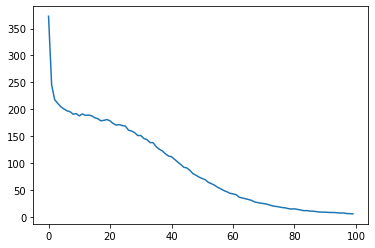

In [14]:
plt.plot(ppl_list)